In [ ]:
import os
import numpy as np
import rawpy
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab import drive
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import torch.nn.functional as F
import random



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
healthy_eye_dir = '/content/drive/My Drive/Data/Healthy'
bacterial_eye_dir = '/content/drive/My Drive/Data/Bacterial'
fungal_eye_dir = '/content/drive/My Drive/Data/Fungal'

In [ ]:
# Define transformation for training (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transformation for validation/test (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# Function to load healthy and bacterial images
def load_healthy_and_bacterial_images(root_folder, label, transform=None):
    images, labels, patients = [], [], []
    for patient_folder in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_folder)
        if os.path.isdir(patient_path):
            for filename in os.listdir(patient_path):
                img_path = os.path.join(patient_path, filename)
                try:
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.cr2')):
                        if filename.lower().endswith('.cr2'):
                            with rawpy.imread(img_path) as raw:
                                rgb = raw.postprocess()
                            img = Image.fromarray(rgb)
                        else:
                            img = Image.open(img_path)

                        if transform:
                            img = transform(img)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(label)
                        patients.append(patient_folder)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)
    patients = np.array(patients)

    return images, labels, patients

# Function to load fungal images (with subfolders)
def load_fungal_images(root_folder, label=2, transform=None):
    images, labels, patients = [], [], []

    # Loop through all subfolders inside the Fungal folder
    for subcategory in os.listdir(root_folder):
        subcategory_path = os.path.join(root_folder, subcategory)
        if os.path.isdir(subcategory_path):
            sub_images, sub_labels, sub_patients = load_healthy_and_bacterial_images(subcategory_path, label, transform)
            images.append(sub_images)
            labels.append(sub_labels)
            patients.append(sub_patients)

    # Concatenate images, labels, and patients from all fungal subfolders
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    patients = np.concatenate(patients, axis=0)

    return images, labels, patients

# Load and resize images for healthy and bacterial datasets
healthy_images, healthy_labels, healthy_patients = load_healthy_and_bacterial_images(healthy_eye_dir, label=0, transform=val_test_transform)
bacterial_images, bacterial_labels, bacterial_patients = load_healthy_and_bacterial_images(bacterial_eye_dir, label=1, transform=val_test_transform)

# Load and resize fungal images
fungal_images, fungal_labels, fungal_patients = load_fungal_images(fungal_eye_dir, label=2, transform=val_test_transform)


In [ ]:
# Patientwise splitting
def patient_split(patient_folders, train_size, val_size, test_size):
    np.random.shuffle(patient_folders)
    train_patients = patient_folders[:train_size]
    val_patients = patient_folders[train_size:train_size + val_size]
    test_patients = patient_folders[train_size + val_size:train_size + val_size + test_size]
    return train_patients, val_patients, test_patients

def filter_images_by_patients(images, labels, patients, selected_patients):
    mask = np.isin(patients, selected_patients)
    filtered_images = images[mask]
    filtered_labels = labels[mask]
    return filtered_images, filtered_labels

# Count the images per patient
healthy_patient_image_count = Counter(healthy_patients)
bacterial_patient_image_count = Counter(bacterial_patients)
fungal_patient_image_count = Counter(fungal_patients)

# Get unique patient folders
healthy_patient_folders = sorted(healthy_patient_image_count.keys())
bacterial_patient_folders = sorted(bacterial_patient_image_count.keys())
fungal_patient_folders = sorted(fungal_patient_image_count.keys())

# Split the patient folders
healthy_train_patients, healthy_val_patients, healthy_test_patients = patient_split(healthy_patient_folders, train_size=100, val_size=22, test_size=22)
bacterial_train_patients, bacterial_val_patients, bacterial_test_patients = patient_split(bacterial_patient_folders, train_size=90, val_size=20, test_size=20)
fungal_train_patients, fungal_val_patients, fungal_test_patients = patient_split(fungal_patient_folders, train_size=138, val_size=30, test_size=30)

# Filter images by patients
X_train_healthy, y_train_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_train_patients)
X_val_healthy, y_val_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_val_patients)
X_test_healthy, y_test_healthy = filter_images_by_patients(healthy_images, healthy_labels, healthy_patients, healthy_test_patients)

X_train_bacterial, y_train_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_train_patients)
X_val_bacterial, y_val_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_val_patients)
X_test_bacterial, y_test_bacterial = filter_images_by_patients(bacterial_images, bacterial_labels, bacterial_patients, bacterial_test_patients)

X_train_fungal, y_train_fungal = filter_images_by_patients(fungal_images, fungal_labels, fungal_patients, fungal_train_patients)
X_val_fungal, y_val_fungal = filter_images_by_patients(fungal_images, fungal_labels, fungal_patients, fungal_val_patients)
X_test_fungal, y_test_fungal = filter_images_by_patients(fungal_images, fungal_labels, fungal_patients, fungal_test_patients)

# Combine the datasets
X_train = np.concatenate((X_train_healthy, X_train_bacterial, X_train_fungal), axis=0)
y_train = np.concatenate((y_train_healthy, y_train_bacterial, y_train_fungal), axis=0)

X_val = np.concatenate((X_val_healthy, X_val_bacterial, X_val_fungal), axis=0)
y_val = np.concatenate((y_val_healthy, y_val_bacterial, y_val_fungal), axis=0)

X_test = np.concatenate((X_test_healthy, X_test_bacterial, X_test_fungal), axis=0)
y_test = np.concatenate((y_test_healthy, y_test_bacterial, y_test_fungal), axis=0)

# Shuffle the combined arrays
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

val_indices = np.arange(X_val.shape[0])
np.random.shuffle(val_indices)
X_val = X_val[val_indices]
y_val = y_val[val_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"Train images shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train images shape: (3473, 3, 224, 224), Train labels shape: (3473,)
Validation images shape: (682, 3, 224, 224), Validation labels shape: (682,)
Test images shape: (760, 3, 224, 224), Test labels shape: (760,)


In [ ]:
# Apply transformations to datasets
def apply_transformations(images, labels, transform):
    transformed_images = []

    if len(images) == 0:
        raise ValueError("The input image array is empty.")

    for idx, img in enumerate(images):
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        if img.ndim == 3 and img.shape[0] == 3:  # Check if image has 3 channels (RGB)
            img = np.transpose(img, (1, 2, 0))  # Convert to (height, width, channels) for PIL
            img_pil = Image.fromarray(img)  # Convert to PIL image

            try:
                # Apply the transformation
                img_transformed = transform(img_pil)
                transformed_images.append(img_transformed)
            except Exception as e:
                print(f"Error applying transformation to image at index {idx}: {e}")
        else:
            print(f"Unexpected image shape at index {idx}: {img.shape}, skipping this image.")

    if not transformed_images:
        raise RuntimeError("No valid transformed images to stack. Ensure that the images are correctly formatted and the transformations are properly applied.")

    # Convert list of transformed images back to a tensor and return
    return torch.stack(transformed_images), torch.tensor(labels)




# Apply transformations to datasets
X_train_transformed, y_train_transformed = apply_transformations(X_train, y_train, train_transform)
X_val_transformed, y_val_transformed = apply_transformations(X_val, y_val, val_test_transform)
X_test_transformed, y_test_transformed = apply_transformations(X_test, y_test, val_test_transform)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_transformed.float(), y_train_transformed.long())
val_dataset = TensorDataset(X_val_transformed.float(), y_val_transformed.long())
test_dataset = TensorDataset(X_test_transformed.float(), y_test_transformed.long())

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data Loaders created:")
print(f"Train loader batch size: {batch_size}")
print(f"Validation loader batch size: {batch_size}")
print(f"Test loader batch size: {batch_size}")



Data Loaders created:
Train loader batch size: 32
Validation loader batch size: 32
Test loader batch size: 32


ResNet50 model without any droput layer results in overfitting.


In [ ]:
# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjusting the final layer for 3 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(val_loader)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the trained model
# torch.save(model.state_dict(), '/content/drive/My Drive/Data/resnet50_model.pth')


Epoch 1/50, Train Loss: 0.5930, Train Accuracy: 0.7115, Val Loss: 0.6808, Val Accuracy: 0.6950
Epoch 2/50, Train Loss: 0.4511, Train Accuracy: 0.7921, Val Loss: 0.7509, Val Accuracy: 0.6569
Epoch 3/50, Train Loss: 0.4352, Train Accuracy: 0.8108, Val Loss: 0.7422, Val Accuracy: 0.6848
Epoch 4/50, Train Loss: 0.3401, Train Accuracy: 0.8520, Val Loss: 0.6283, Val Accuracy: 0.7214
Epoch 5/50, Train Loss: 0.2578, Train Accuracy: 0.8952, Val Loss: 0.7438, Val Accuracy: 0.6730
Epoch 6/50, Train Loss: 0.2262, Train Accuracy: 0.9067, Val Loss: 0.8083, Val Accuracy: 0.7038
Epoch 7/50, Train Loss: 0.2067, Train Accuracy: 0.9211, Val Loss: 0.8587, Val Accuracy: 0.7185
Epoch 8/50, Train Loss: 0.1711, Train Accuracy: 0.9344, Val Loss: 1.2812, Val Accuracy: 0.7126
Epoch 9/50, Train Loss: 0.1564, Train Accuracy: 0.9387, Val Loss: 1.2410, Val Accuracy: 0.7141
Epoch 10/50, Train Loss: 0.1220, Train Accuracy: 0.9551, Val Loss: 1.0373, Val Accuracy: 0.7331
Epoch 11/50, Train Loss: 0.0788, Train Accuracy: 

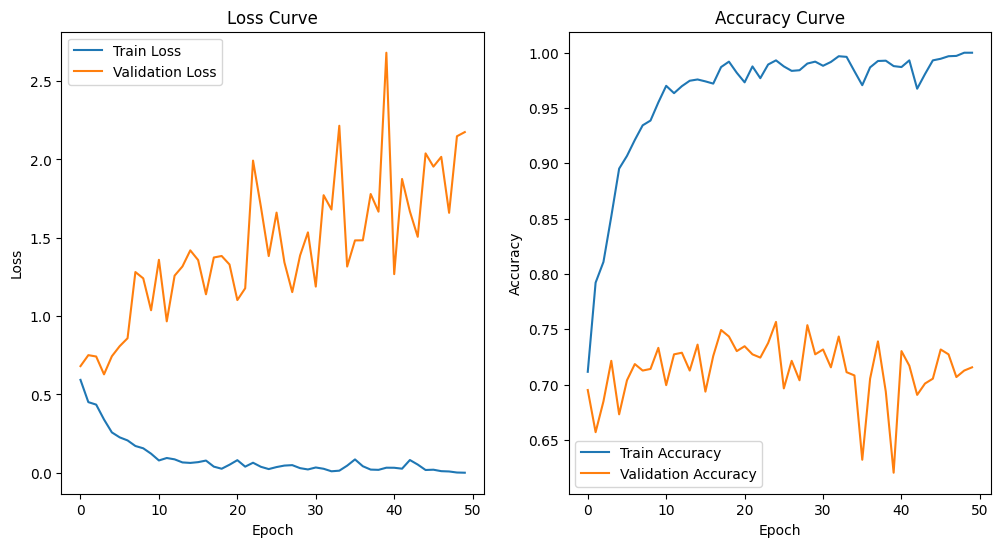

In [ ]:
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


The above result clearly shows overfitting.


Sensitivity: [0.99509804 0.48704663 0.70523416]
Specificity: [0.99817518 0.82508834 0.7364532 ]
Accuracy: 0.7276


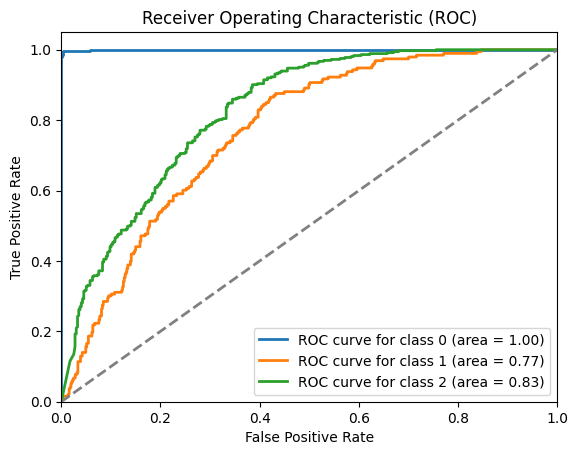

In [ ]:
import torch.nn.functional as F

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    sensitivities = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate for each class
    specificities = np.array([
        (np.sum(cm) - (np.sum(cm, axis=0)[i] + np.sum(cm, axis=1)[i] - cm[i, i])) / (np.sum(cm) - np.sum(cm, axis=0)[i])
        for i in range(num_classes)
    ])  # True Negative Rate for each class

    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    return sensitivities, specificities, accuracy

def plot_roc_curve(y_true, y_scores, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Get probabilities for all classes
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate metrics
sensitivities, specificities, accuracy = calculate_metrics(y_true, y_pred)
print(f"Sensitivity: {sensitivities}")
print(f"Specificity: {specificities}")
print(f"Accuracy: {accuracy:.4f}")

# Plotting ROC curve
num_classes = y_scores.shape[1]
plot_roc_curve(y_true, y_scores, num_classes)

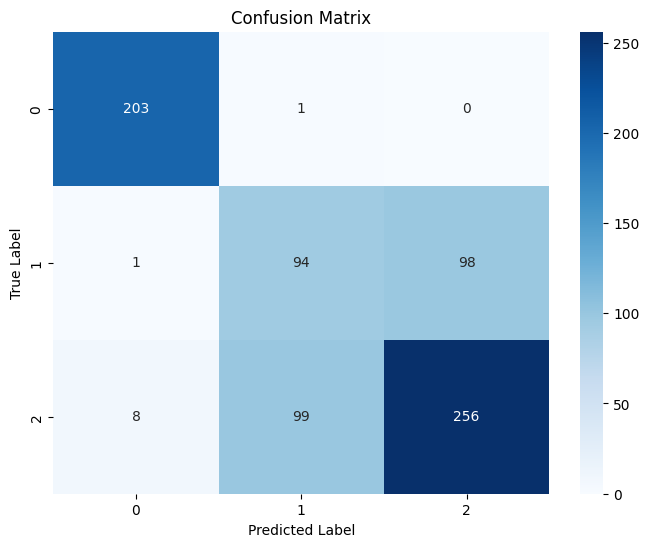

In [ ]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

labels = [0, 1, 2]  # Healthy, Bacterial, Fungal
plot_confusion_matrix(y_true, y_pred, labels)


Adding dropout to prevent Overfitting.


In [ ]:
#This is the final selected model.
#A dropout layer with a 50% dropout is added before the final fully connected layer.

# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True)


class ResNet50Custom(nn.Module):
    def __init__(self):
        super(ResNet50Custom, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Freeze the pre-trained layers if desired
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Modify the fully connected layer to include dropout
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout with probability of 50%
            nn.Linear(self.resnet.fc.in_features, 3)  # Final layer for 3 classes
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate the custom model
model = ResNet50Custom()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50Custom(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def evaluate_model(loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(val_loader)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the trained model
# torch.save(model.state_dict(), '/content/drive/My Drive/Data/resnet50_model.pth')


Epoch 1/50, Train Loss: 0.7663, Train Accuracy: 0.6289, Val Loss: 0.6316, Val Accuracy: 0.6921
Epoch 2/50, Train Loss: 0.5983, Train Accuracy: 0.7167, Val Loss: 0.6133, Val Accuracy: 0.6994
Epoch 3/50, Train Loss: 0.5740, Train Accuracy: 0.7262, Val Loss: 0.6482, Val Accuracy: 0.7023
Epoch 4/50, Train Loss: 0.5712, Train Accuracy: 0.7201, Val Loss: 0.6345, Val Accuracy: 0.6657
Epoch 5/50, Train Loss: 0.5181, Train Accuracy: 0.7604, Val Loss: 0.6866, Val Accuracy: 0.7009
Epoch 6/50, Train Loss: 0.5503, Train Accuracy: 0.7426, Val Loss: 0.6008, Val Accuracy: 0.7155
Epoch 7/50, Train Loss: 0.5341, Train Accuracy: 0.7386, Val Loss: 0.7485, Val Accuracy: 0.6774
Epoch 8/50, Train Loss: 0.5459, Train Accuracy: 0.7443, Val Loss: 0.8054, Val Accuracy: 0.6672
Epoch 9/50, Train Loss: 0.5243, Train Accuracy: 0.7455, Val Loss: 0.6454, Val Accuracy: 0.7023
Epoch 10/50, Train Loss: 0.5429, Train Accuracy: 0.7328, Val Loss: 0.6593, Val Accuracy: 0.7155
Epoch 11/50, Train Loss: 0.5225, Train Accuracy: 

Sensitivity: [0.98039216 0.34715026 0.76033058]
Specificity: [0.99274047 0.79378069 0.75698324]
Accuracy: 0.7145


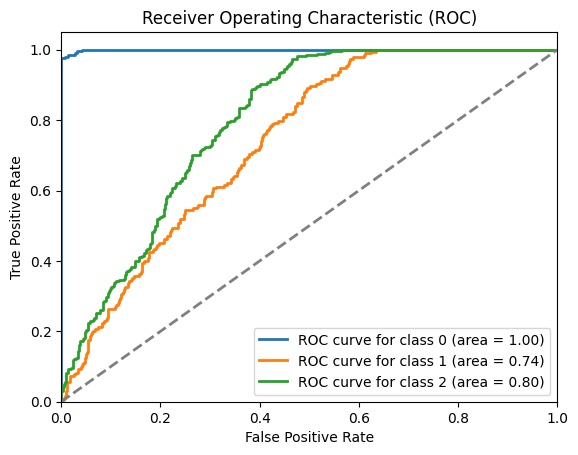

In [ ]:

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    sensitivities = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate for each class
    specificities = np.array([
        (np.sum(cm) - (np.sum(cm, axis=0)[i] + np.sum(cm, axis=1)[i] - cm[i, i])) / (np.sum(cm) - np.sum(cm, axis=0)[i])
        for i in range(num_classes)
    ])  # True Negative Rate for each class

    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    return sensitivities, specificities, accuracy

def plot_roc_curve(y_true, y_scores, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Get probabilities for all classes
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate metrics
sensitivities, specificities, accuracy = calculate_metrics(y_true, y_pred)
print(f"Sensitivity: {sensitivities}")
print(f"Specificity: {specificities}")
print(f"Accuracy: {accuracy:.4f}")

# Plotting ROC curve
num_classes = y_scores.shape[1]
plot_roc_curve(y_true, y_scores, num_classes)

A dropout layer with a 50% drop probability before the final fully connected layer prevents overfitting and gives the accuracy of 71.45%. This is the selected model.

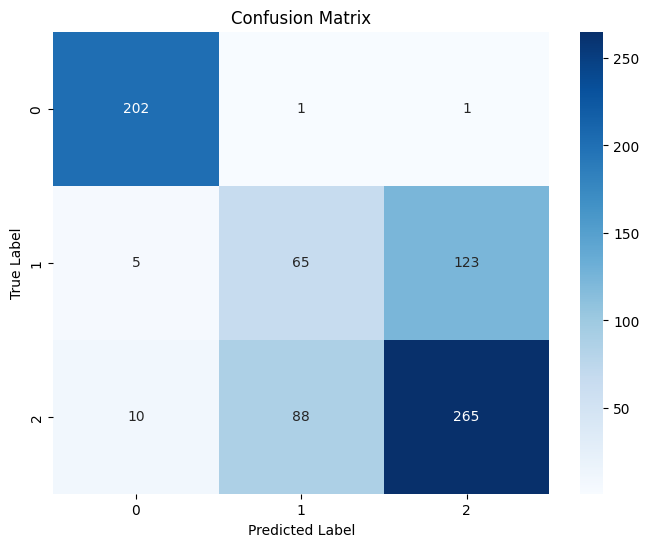

In [ ]:

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

labels = [0, 1, 2]  # Healthy, Bacterial, Fungal
plot_confusion_matrix(y_true, y_pred, labels)


In [ ]:
#Multiple dropout layers with weight decay (L2 regularization), learning rate scheduling.
from torch.optim.lr_scheduler import StepLR

# Define the custom ResNet50 model with multiple dropout layers
class ResNet50Custom(nn.Module):
    def __init__(self):
        super(ResNet50Custom, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Freeze the pre-trained layers if desired
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Customize fully connected layer and add dropout
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout layer with 50% probability
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),  # Activation layer
            nn.Dropout(p=0.5),  # Add another dropout for further regularization
            nn.Linear(512, 3)   # Final layer for 3 classes
        )

    def forward(self, x):
        return self.resnet(x)


model = ResNet50Custom()

# Move model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Adding weight decay (L2 regularization) to the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay term added

# Implement a learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Reduce LR every 7 epochs by a factor of 0.1

# Training parameters
num_epochs = 50

# Define the training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()  # Step the learning rate scheduler

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Early stopping: stop if validation loss does not improve for several epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

        # Print statistics
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.7631, Train Accuracy: 0.6219, Val Loss: 0.7080, Val Accuracy: 0.6437
Epoch 2/50, Train Loss: 0.5966, Train Accuracy: 0.6870, Val Loss: 0.6042, Val Accuracy: 0.7009
Epoch 3/50, Train Loss: 0.5829, Train Accuracy: 0.6985, Val Loss: 0.6742, Val Accuracy: 0.6994
Epoch 4/50, Train Loss: 0.5600, Train Accuracy: 0.7213, Val Loss: 0.6349, Val Accuracy: 0.6994
Epoch 5/50, Train Loss: 0.5570, Train Accuracy: 0.7285, Val Loss: 0.6004, Val Accuracy: 0.7082
Epoch 6/50, Train Loss: 0.5373, Train Accuracy: 0.7276, Val Loss: 0.6173, Val Accuracy: 0.7053
Epoch 7/50, Train Loss: 0.5427, Train Accuracy: 0.7394, Val Loss: 0.5824, Val Accuracy: 0.7199
Epoch 8/50, Train Loss: 0.5201, Train Accuracy: 0.7495, Val Loss: 0.5945, Val Accuracy: 0.7111
Epoch 9/50, Train Loss: 0.4996, Train Accuracy: 0.7501, Val Loss: 0.5976, Val Accuracy: 0.7126
Epoch 10/50, Train Loss: 0.5063, Train Accuracy: 0.7483, Val Loss: 0.5920, Val Accuracy: 0.7155
Epoch 11/50, Train Loss: 0.5044, Train Accuracy: 

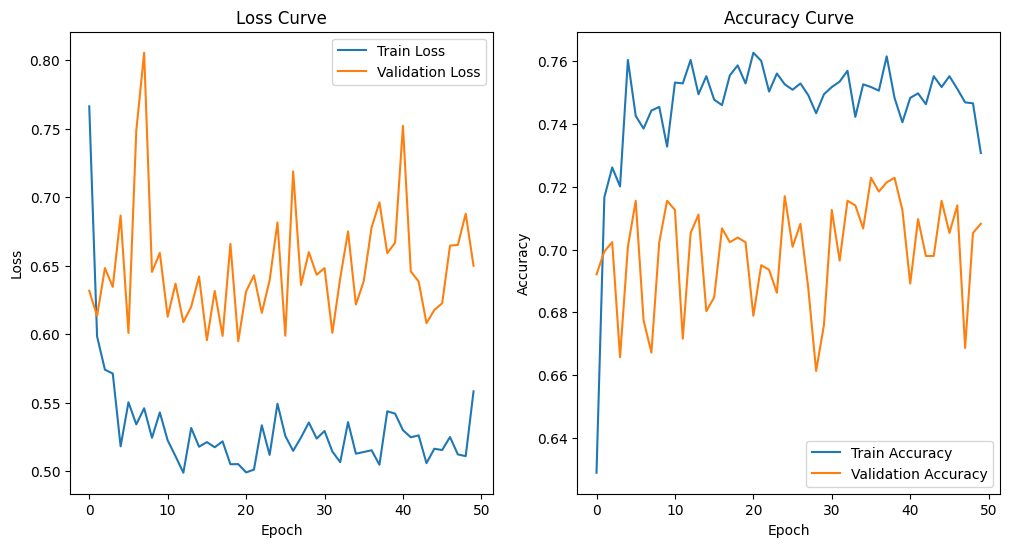

In [ ]:
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Sensitivity: [0.99019608 0.33678756 0.73002755]
Specificity: [0.99631676 0.78877888 0.73584906]
Accuracy: 0.7000


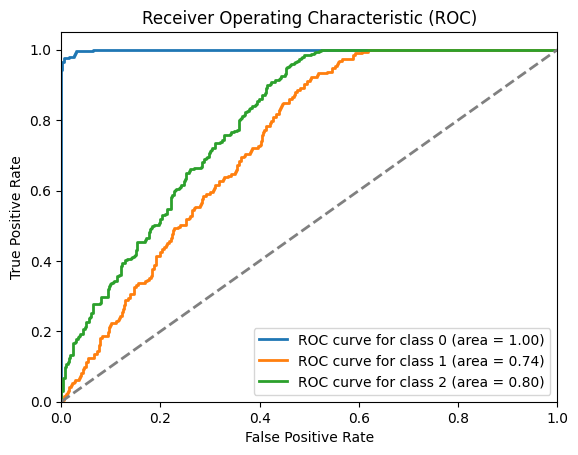

In [ ]:
import torch.nn.functional as F

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    sensitivities = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate for each class
    specificities = np.array([
        (np.sum(cm) - (np.sum(cm, axis=0)[i] + np.sum(cm, axis=1)[i] - cm[i, i])) / (np.sum(cm) - np.sum(cm, axis=0)[i])
        for i in range(num_classes)
    ])  # True Negative Rate for each class

    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    return sensitivities, specificities, accuracy

def plot_roc_curve(y_true, y_scores, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Get probabilities for all classes
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate metrics
sensitivities, specificities, accuracy = calculate_metrics(y_true, y_pred)
print(f"Sensitivity: {sensitivities}")
print(f"Specificity: {specificities}")
print(f"Accuracy: {accuracy:.4f}")

# Plotting ROC curve
num_classes = y_scores.shape[1]
plot_roc_curve(y_true, y_scores, num_classes)

Multiple dropout layers with weight decay (L2 regularization) prevents overfitting but gives accuracy of 70%.

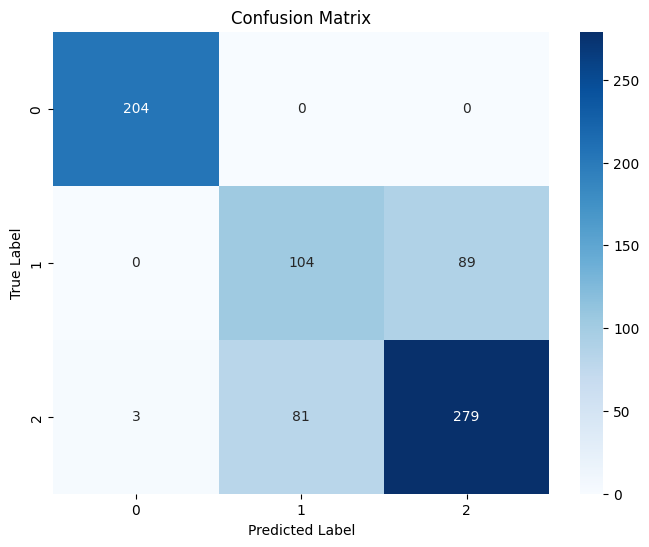

In [ ]:

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

labels = [0, 1, 2]  # Healthy, Bacterial, Fungal
plot_confusion_matrix(y_true, y_pred, labels)


In [ ]:
#the resnet50 model with unfreezing more layers and less dropout


class ResNet50Custom(nn.Module):
    def __init__(self):
        super(ResNet50Custom, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Unfreeze layers starting from layer4
        for name, param in self.resnet.named_parameters():
            if 'layer4' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Customize fully connected layer and add dropout
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.4),  # Reduced dropout layer with 40% probability
            nn.Linear(self.resnet.fc.in_features, 512),  # Additional fully connected layer
            nn.ReLU(),  # Activation layer
            nn.Dropout(p=0.3),  # Another reduced dropout
            nn.Linear(512, 3)   # Final layer for 3 classes
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
model = ResNet50Custom()

# Move model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Adding weight decay (L2 regularization) to the optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Implement a learning rate scheduler to reduce the learning rate when validation performance plateaus
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Reduce LR every 7 epochs by a factor of 0.1

# Training parameters
num_epochs = 50

# Define the training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()  # Step the learning rate scheduler

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Save the best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

        # Print statistics
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Load the best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50, Train Loss: 0.4957, Train Accuracy: 0.7668, Val Loss: 0.5871, Val Accuracy: 0.7375
Epoch 2/50, Train Loss: 0.2230, Train Accuracy: 0.9119, Val Loss: 1.3171, Val Accuracy: 0.7023
Epoch 3/50, Train Loss: 0.1395, Train Accuracy: 0.9508, Val Loss: 0.8855, Val Accuracy: 0.7419
Epoch 4/50, Train Loss: 0.0870, Train Accuracy: 0.9695, Val Loss: 0.8818, Val Accuracy: 0.7463
Epoch 5/50, Train Loss: 0.0534, Train Accuracy: 0.9830, Val Loss: 1.4643, Val Accuracy: 0.7331
Epoch 6/50, Train Loss: 0.0455, Train Accuracy: 0.9827, Val Loss: 1.5557, Val Accuracy: 0.7346
Epoch 7/50, Train Loss: 0.0511, Train Accuracy: 0.9813, Val Loss: 1.1074, Val Accuracy: 0.7287
Epoch 8/50, Train Loss: 0.0174, Train Accuracy: 0.9948, Val Loss: 1.2595, Val Accuracy: 0.7493
Epoch 9/50, Train Loss: 0.0081, Train Accuracy: 0.9988, Val Loss: 1.3369, Val Accuracy: 0.7493
Epoch 10/50, Train Loss: 0.0040, Train Accuracy: 0.9997, Val Loss: 1.3962, Val Accuracy: 0.7551
Epoch 11/50, Train Loss: 0.0072, Train Accuracy: 

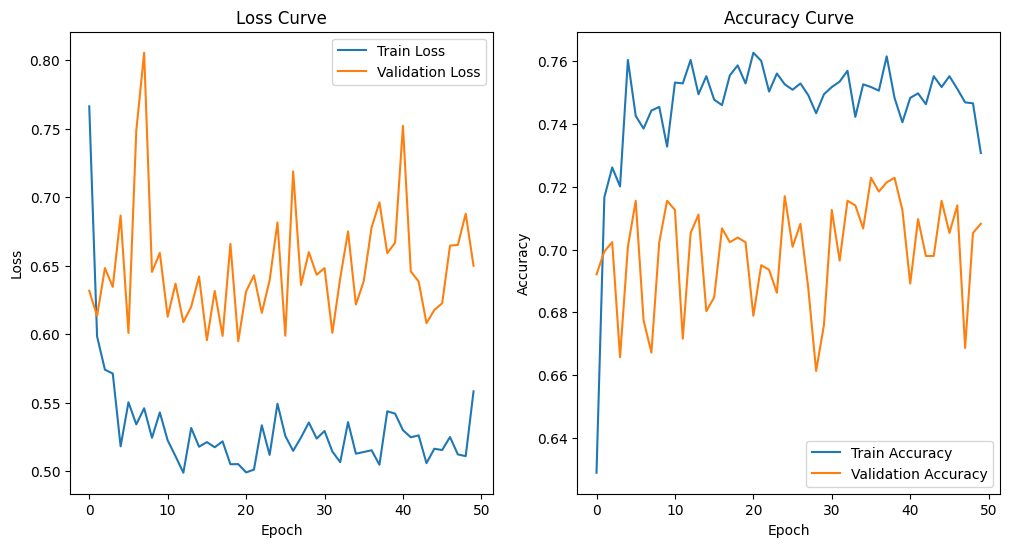

In [ ]:
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Sensitivity: [1.         0.5388601  0.76859504]
Specificity: [1.         0.84521739 0.78571429]
Accuracy: 0.7724


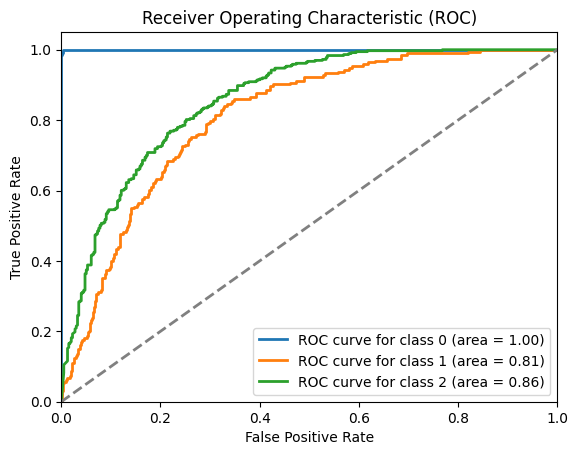

In [ ]:
import torch.nn.functional as F

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    sensitivities = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate for each class
    specificities = np.array([
        (np.sum(cm) - (np.sum(cm, axis=0)[i] + np.sum(cm, axis=1)[i] - cm[i, i])) / (np.sum(cm) - np.sum(cm, axis=0)[i])
        for i in range(num_classes)
    ])  # True Negative Rate for each class

    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    return sensitivities, specificities, accuracy

def plot_roc_curve(y_true, y_scores, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Get probabilities for all classes
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Calculate metrics
sensitivities, specificities, accuracy = calculate_metrics(y_true, y_pred)
print(f"Sensitivity: {sensitivities}")
print(f"Specificity: {specificities}")
print(f"Accuracy: {accuracy:.4f}")

# Plotting ROC curve
num_classes = y_scores.shape[1]
plot_roc_curve(y_true, y_scores, num_classes)

Unfreezing more layers result in overfitting again. So, it seems adding a dropout layer of 0.5 gives the best result.